# Data Loading, Cleaning and Wrangling

In [1]:
#Need to run this to have the right path
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

#Installing the right stuff
!pip install -q sentencepiece
!pip install -q transformers
!pip install -q evaluate
!pip install -q rouge_score
!pip install pydot


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 380.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
#Importing necessary libraries
import pandas as pd
import numpy as np
import evaluate
from pprint import pprint
# from transformers import T5Tokenizer, TFT5ForConditionalGeneration

from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from collections import Counter
import numpy as np
import tensorflow as tf
from tensorflow import keras

import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint

from transformers import BertTokenizer, TFBertModel
import random

np.random.seed(1)


ModuleNotFoundError: No module named 'evaluate'

In [ ]:
#Building path and opening the files to create the dataframe
data_path = "/content/drive/MyDrive/266 NLP - Final Project/all_the_news_SUBSET_Kaggle/"

df1 = pd.read_csv(data_path + "articles1.csv").iloc[:, 1:]
df2 = pd.read_csv(data_path + "articles2.csv").iloc[:, 1:]
df3 = pd.read_csv(data_path + "articles3.csv").iloc[:, 1:]

data = pd.concat([df1, df2, df3])

In [ ]:
### Data Characteristics
## Each id is unique to each row/headline with no duplicate articles/rows
## 142,570 total headline and articles

## 1.85% of the data doesn't have dates but I feel like it's ok to get rid of them since it's such a small sample
data[data["date"].isnull()].shape[0]/data.shape[0]
data = data[~data["date"].isnull()]

## Out of all the articles, 99.7% of them are from 2015-2017 so it might not be helpful to keep the older articles before 2015 since there are so few
data.value_counts("year").sort_index(ascending=False)
data = data[data["year"]>2014]

data = data.reset_index()

#Added word count column
data['article_wd_ct'] = data['content'].str.split().str.len() ## word count of each article

## Only subsetting for article that have at least 100 words- could do more analysis into including ones between 70-100 but the ones I've seen in that range aren't fully populated articles or poorly extracted articles
data = data[data["article_wd_ct"]>=100]

## Further subsetting the data for articles below 500 words for ease of running the models
data = data[data["article_wd_ct"]<=500]

Data Cleaning for Headlines.

A manual process done publication by publication

In [ ]:
#Atlantic
data = data.drop(data.loc[(data.publication=="Atlantic") & (data.title.str.contains("Atlantic"))].index)

#Breitbart
data.loc[((data.publication=="Breitbart") & (data.title.str.contains("- Breitbart"))), "title"] = data[(data["publication"] == "Breitbart") & (data["title"].str.contains("- Breitbart"))].title.str[:-12]
data = data.drop(data.loc[(data.publication=="Breitbart") & ( (data.title.str.contains("Breitbart")) | (data.title.str.contains("BREITBART")) )].index)

#Business Insider
data = data.drop(data.loc[(data.publication=="Business Insider") & ((data.title.str.contains("Business Insider")) | (data.title.str.contains("BUSINESS INSIDER")) )].index)

#BuzzFeed
data = data.drop(data.loc[(data.publication=="Buzzfeed News") & ((data.title.str.contains("BuzzFeed")) | (data.title.str.contains("BUZZFEED")) )].index)

#CNN
data = data.drop(data.loc[(data.publication=="CNN") & (data.title.str.contains("CNN"))].index)

#Fox News
#Fix all the aforementioned appendings. Data frame should be equal size to above, 53089, can use that to validate.
data.loc[((data.publication=="Fox News") & (data.title.str.contains("Fox News Poll:"))), "title"] = data[(data["publication"] == "Fox News") & (data["title"].str.contains("Fox News Poll:"))].title.str[15:]
data.loc[((data.publication=="Fox News") & (data.title.str.contains("Fox News Electoral Scorecard:"))), "title"] = data[(data["publication"] == "Fox News") & (data["title"].str.contains("Fox News Electoral Scorecard:"))].title.str[30:]
data.loc[((data.publication=="Fox News") & (data.title.str.contains("Fox News projects:"))), "title"] = data[(data["publication"] == "Fox News") & (data["title"].str.contains("Fox News projects:"))].title.str[19:]
data = data.drop(data.loc[(data.publication=="Fox News") & ((data.title.str.contains("Fox")) | (data.title.str.contains("FOX")) )].index)

#Guardian
data = data.drop(data.loc[(data.publication=="Guardian") & (data.title.str.contains("Guardian"))].index)

#National Review
data = data.drop(data.loc[(data.publication=="National Review") & ( (data.title.str.contains("NR ")) | (data.title.str.contains("NR:")) | (data.title.str.contains("NRI")) | (data.title.str.contains("NRO")) )].index)

#New York Post
data = data.drop(data.loc[(data.publication=="New York Post") & (data.title.str.contains("New York Post"))].index)

#New York Times
data.loc[data.publication=="New York Times", "title"] = data[data['publication'] == "New York Times"].title.str[:-21]
data = data.drop(data.loc[(data.publication=="New York Times") & (data.title.str.contains("New York Times"))].index)

#NPR
data = data.drop(data.loc[(data.publication=="NPR") & (data.title.str.contains("NPR"))].index)

#Reuters
data = data.drop(data.loc[(data.publication=="Reuters") & (data.title.str.contains("Reuters"))].index)

#Talking Points Memo
data = data.drop(data.loc[(data.publication=="Talking Points Memo") & (data.title.str.contains("TPM"))].index)

#Vox
data = data.drop(data.loc[(data.publication=="Vox") & (data.title.str.contains("Vox"))].index)

#Washington Post
data = data.drop(data.loc[(data.publication=="Washington Post") & (data.title.str.contains("Washington Post"))].index)

In [ ]:
data

,index,id,title,publication,author,date,year,month,url,content,article_wd_ct
5,5,17288,"Sick With a Cold, Queen Elizabeth Misses New Y...",New York Times,Sewell Chan,2017-01-02,2017.0,1.0,NaN,"LONDON — Queen Elizabeth II, who has been b...",159
19,19,17303,Fecal Pollution Taints Water at Melbourne’s Be...,New York Times,Brett Cole,2017-01-03,2017.0,1.0,NaN,"SYDNEY, Australia — The annual beach pilgri...",292
33,33,17323,"Airline Pilot, Believed to Be Drunk, Is Pulled...",New York Times,Ian Austen,2017-01-03,2017.0,1.0,NaN,OTTAWA — It was 7 a. m. and 99 passengers a...,410
47,47,17338,It’s Time to Ignore Advice About Which Stocks ...,New York Times,Damon Darlin,2017-01-09,2017.0,1.0,NaN,It’s that time of year when financial advice s...,395
52,52,17344,Chinese City Official Shoots 2 Others and Kill...,New York Times,Chris Buckley and Adam Wu,2017-01-05,2017.0,1.0,NaN,BEIJING — A city official in southwest Chin...,358
...,...,...,...,...,...,...,...,...,...,...,...
139478,42535,218042,Debbie Reynolds was a trouper all the way to t...,Washington Post,Ann Hornaday,2016-12-29,2016.0,12.0,https://web.archive.org/web/20161230000842/htt...,Y ou can almost hear Carrie Fishe...,367
139487,42544,218051,An obscure E.U. regulation may have saved live...,Washington Post,Adam Taylor,2016-12-29,2016.0,12.0,https://web.archive.org/web/20161230000842/htt...,The truck attack on a Christmas market in...,387
139492,42549,218056,A woman ordered canaries to brighten her home....,Washington Post,Avi Selk,2016-12-29,2016.0,12.0,https://web.archive.org/web/20161230000842/htt...,"Somewhere between Texas and Alabama, some...",373
139494,42551,218063,"Trump praises Putin’s response to sanctions, c...",Washington Post,Karoun Demirjian,2016-12-30,2016.0,12.0,https://web.archive.org/web/20161231004909/htt...,Donald Trump on Friday expressed his ap...,314


In [ ]:
data.publication.value_counts().reset_index()

,index,publication
0,Breitbart,14959
1,New York Post,11427
2,Business Insider,4047
3,CNN,4042
4,Reuters,3192
5,NPR,3052
6,Fox News,2222
7,Buzzfeed News,2076
8,Guardian,1901
9,Talking Points Memo,1717


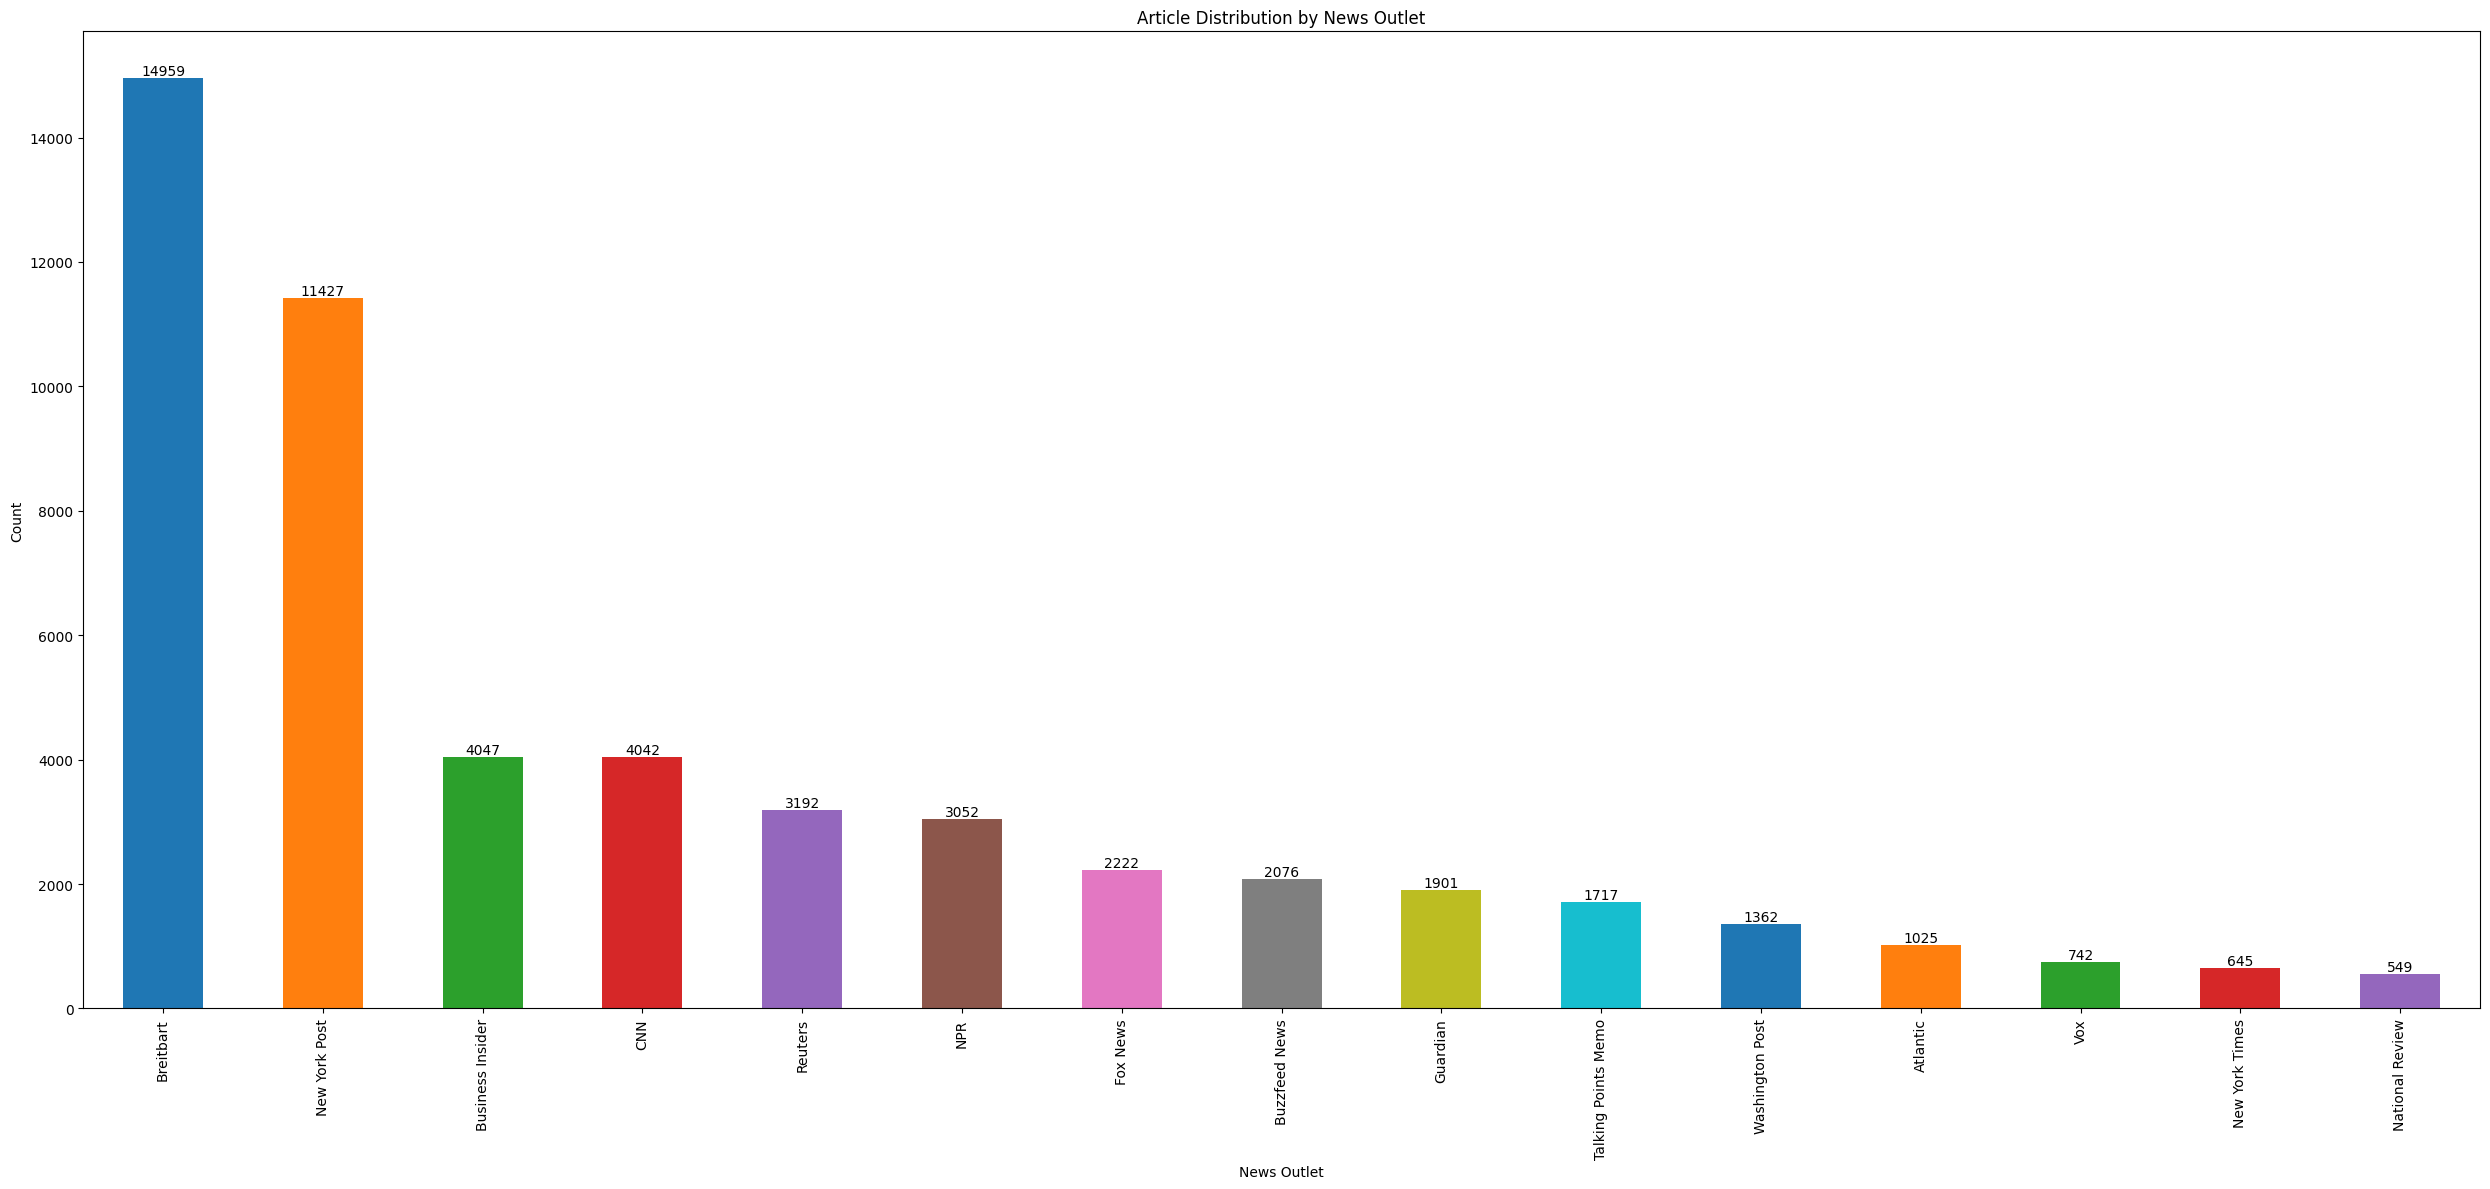

In [ ]:
import matplotlib.pyplot as plt

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
plt.figure(figsize=(25,12))
ax = data.publication.value_counts().plot(kind="bar", title="Article Distribution by News Outlet", color=colors, ylabel="Count", xlabel="News Outlet")
ax.bar_label(ax.containers[0], label_type='edge')
plt.tight_layout()


# Predicting the news outlet based off article

In [ ]:
## Subsetting data to top 6 publications only since they have >1000 articles
final_publications = (data.publication.value_counts()).index[data.publication.value_counts()>1000].values
final_data = data[data.publication.isin(final_publications)]

## Sampling 1000 articles from each publication for equal training and testing sizes
final_data = final_data.groupby("publication").apply(lambda x: x.sample(1000, random_state=1)).reset_index(drop=True)

## Assigning numerical label to publication
pub_mapping = {j:i for i, j in enumerate(final_data.publication.unique())}
final_data["publication_id"] = final_data["publication"]
final_data = final_data.replace({"publication_id":pub_mapping})

final_data = final_data.reset_index()


In [ ]:
final_data.publication.value_counts()

Atlantic               1000
Breitbart              1000
Business Insider       1000
Buzzfeed News          1000
CNN                    1000
Fox News               1000
Guardian               1000
NPR                    1000
New York Post          1000
Reuters                1000
Talking Points Memo    1000
Washington Post        1000
Name: publication, dtype: int64

In [ ]:
def convert_to_lists(data, test_size=0.2):
  articles = data["content"].values
  labels = data["publication_id"].values
  target_names = list(data["publication"].unique())
  return train_test_split(articles, labels, test_size=test_size, random_state=1), target_names

(train_texts, test_texts, train_labels, test_labels), target_names = convert_to_lists(data=final_data)
len(train_texts), len(test_texts), len(train_labels), len(test_labels), len(target_names)


(9600, 2400, 9600, 2400, 12)

In [ ]:
num = 8640
valid_texts = train_texts[num:]
valid_labels = train_labels[num:]
train_texts = train_texts[:num]
train_labels = train_labels[:num]

#get the labels in a needed data format for validation
npvalid_labels = np.asarray(valid_labels)

train_texts = list(train_texts)
valid_texts = list(valid_texts)
test_texts = list(test_texts)


In [ ]:
#make it easier to use a variety of BERT subword models
model_checkpoint = 'bert-base-cased'
max_length = 500

bert_tokenizer = BertTokenizer.from_pretrained(model_checkpoint)
bert_model = TFBertModel.from_pretrained(model_checkpoint)

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
## Separating the encodings
train_encodings = bert_tokenizer(train_texts, truncation=True, padding=True, max_length=max_length, return_tensors='tf')
valid_encodings = bert_tokenizer(valid_texts, truncation=True, padding=True, max_length=max_length, return_tensors='tf')
test_encodings = bert_tokenizer(test_texts, truncation=True, padding=True, max_length=max_length, return_tensors='tf')

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.96 µs


In [ ]:
def create_bert_multiclass_model(checkpoint = model_checkpoint,
                                 MAX_SEQUENCE_LENGTH = max_length,
                                 num_classes = 12,
                                 hidden_size = max_length+1,
                                 dropout=0.3,
                                 learning_rate):
    bert_model.trainable = True

    input_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}

    bert_out = bert_model(bert_inputs)

    pooler_token = bert_out[1]

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(pooler_token)

    hidden = tf.keras.layers.Dropout(dropout)(hidden)

    classification = tf.keras.layers.Dense(num_classes, activation='softmax',name='classification_layer')(hidden)

    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])

    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss="sparse_categorical_crossentropy",
                                 metrics='accuracy')

    return classification_model

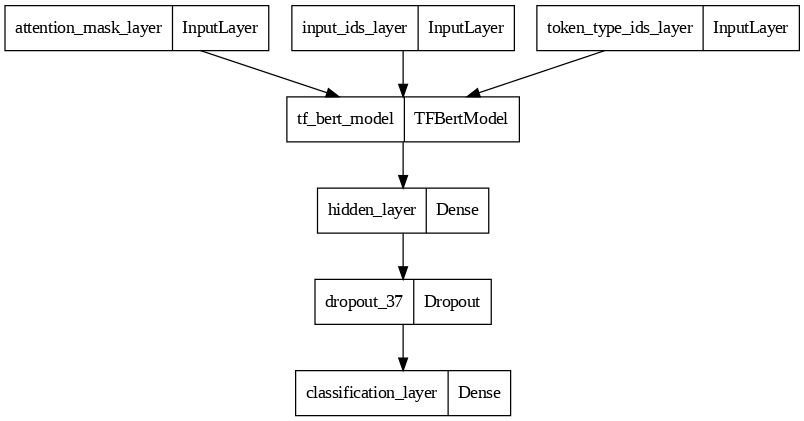

In [ ]:
pooler_bert_model = create_bert_multiclass_model(checkpoint=model_checkpoint, learning_rate=0.00008)
keras.utils.plot_model(pooler_bert_model, show_shapes=False, show_dtype=False, show_layer_names=True, dpi=90)


In [ ]:
pooler_bert_model.summary()
%time
pooler_bert_model_history = pooler_bert_model.fit([train_encodings.input_ids, train_encodings.token_type_ids, train_encodings.attention_mask],
                                                  train_labels,
                                                  validation_data=([valid_encodings.input_ids, valid_encodings.token_type_ids, valid_encodings.attention_mask],
                                                  npvalid_labels),
                                                  batch_size=8,
                                                  epochs=1)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask_layer (Inpu  [(None, 500)]                0         []                            
 tLayer)                                                                                          
                                                                                                  
 input_ids_layer (InputLaye  [(None, 500)]                0         []                            
 r)                                                                                               
                                                                                                  
 token_type_ids_layer (Inpu  [(None, 500)]                0         []                            
 tLayer)                                                                                      

In [ ]:
score = pooler_bert_model.evaluate([test_encodings.input_ids, test_encodings.token_type_ids, test_encodings.attention_mask],
                                                  test_labels)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

75/75 [==============================] - 97s 1s/step - loss: 0.7243 - accuracy: 0.7683
Test loss: 0.7243072390556335
Test accuracy: 0.7683333158493042


In [ ]:
predictions_model1 = pooler_bert_model.predict([test_encodings.input_ids, test_encodings.token_type_ids, test_encodings.attention_mask])
predictions_model1 = tf.argmax(predictions_model1, axis=-1)
predictions_model1

75/75 [==============================] - 94s 1s/step


<tf.Tensor: shape=(2400,), dtype=int64, numpy=array([7, 5, 1, ..., 5, 1, 6])>

In [ ]:
print(classification_report(test_labels, predictions_model1.numpy(), target_names=target_names))
cm = tf.math.confusion_matrix(test_labels, predictions_model1)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

                     precision    recall  f1-score   support

           Atlantic       1.00      0.83      0.90       223
          Breitbart       0.93      0.93      0.93       190
   Business Insider       1.00      0.92      0.96       210
      Buzzfeed News       0.89      0.48      0.62       194
                CNN       1.00      1.00      1.00       233
           Fox News       0.47      0.62      0.54       187
           Guardian       0.55      0.71      0.62       178
                NPR       0.80      0.69      0.74       175
      New York Post       0.50      0.76      0.60       200
            Reuters       0.98      0.92      0.95       206
Talking Points Memo       0.81      0.80      0.80       204
    Washington Post       0.57      0.48      0.52       200

           accuracy                           0.77      2400
          macro avg       0.79      0.76      0.77      2400
       weighted avg       0.80      0.77      0.77      2400



Text(220.72222222222223, 0.5, 'True')

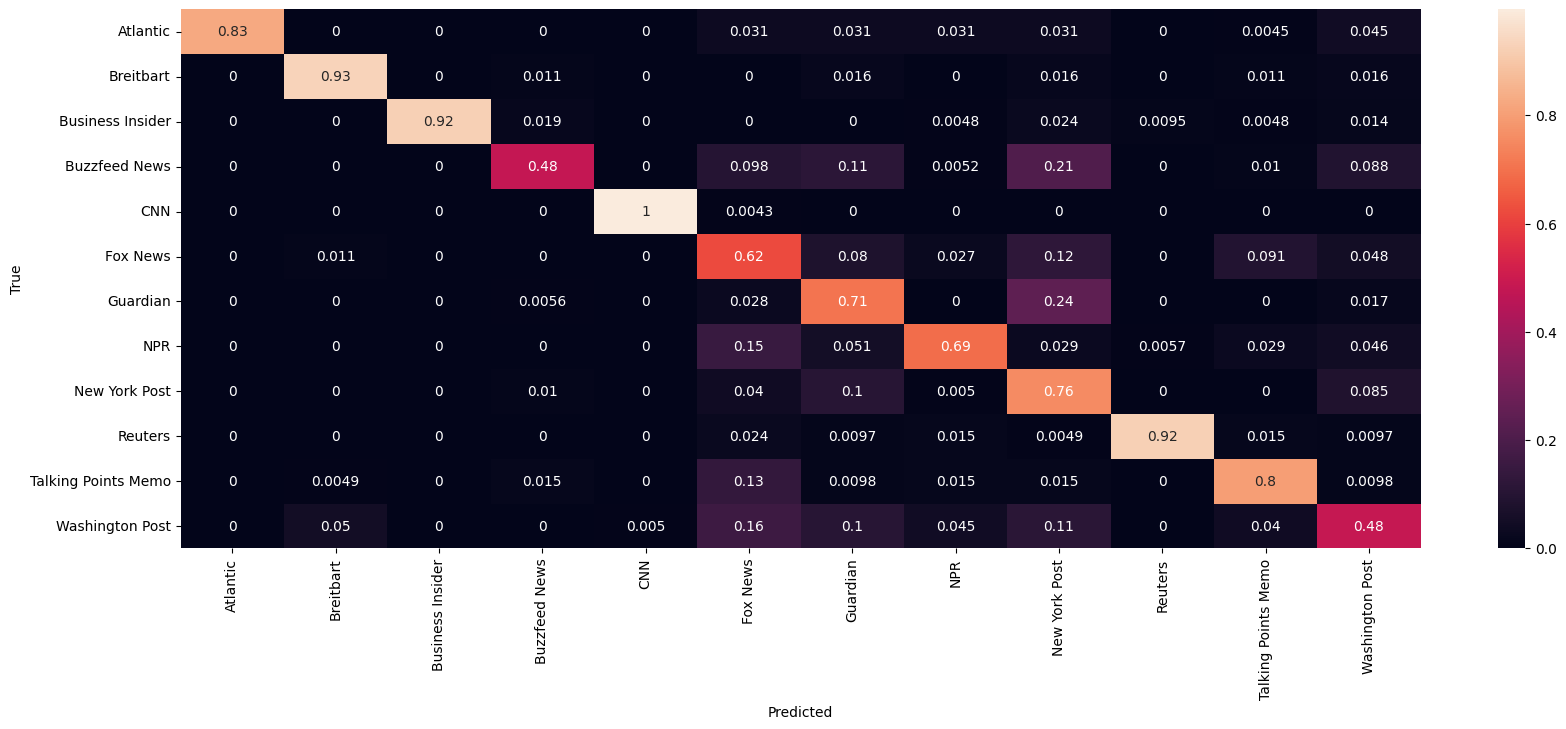

In [ ]:
plt.figure(figsize=(20,7))
sns.heatmap(
    cm, annot=True,
    xticklabels=target_names,
    yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("True")